## Dev Notebook 2024-11

In [1]:
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import expand_labels
from skimage.measure import label
import skimage
import numpy as np
import os,sys 

In [2]:
path = os.path.abspath(os.path.join(os.path.join(os.path.abspath(""), os.pardir), os.pardir))
print(path)
sys.path.insert(1,path)
import neurotorchmz
from neurotorchmz.utils.image import ImgObj
from neurotorchmz.utils.synapse_detection import *
print(neurotorchmz.__version__)
%matplotlib inline

d:\Eigene Datein\Programmieren\Git\abrilka\neurotorch
24.11.5_alpha


In [3]:
neurotorchmz.Start_Background(neurotorchmz.Edition.NEUROTORCH_DEBUG)
print(neurotorchmz.__version__)

24.11.5_alpha


Error while Detecting using Advanced Polygonal Detection in label 3; len(contour) = 2, lowerThreshold = 2, upperThreshold = 40, minArea = 20
  (y,x)0 = [118.1 123. ], [118.  122.9]; len = 217
  (y,x)0 = [38.1 23. ], [38.  22.9]; len = 15
Error while Detecting using Advanced Polygonal Detection in label 4; len(contour) = 2, lowerThreshold = 2, upperThreshold = 40, minArea = 20
  (y,x)0 = [134.1 154. ], [134.  153.9]; len = 187
  (y,x)0 = [22.1  1. ], [22.   0.9]; len = 5
Error while Detecting using Advanced Polygonal Detection in label 5; len(contour) = 3, lowerThreshold = 2, upperThreshold = 40, minArea = 20
  (y,x)0 = [179.1 455. ], [179.  454.9]; len = 217
  (y,x)0 = [27.1  2. ], [27.   1.9]; len = 7
  (y,x)0 = [29.1  3. ], [29.   2.9]; len = 7
Error while Detecting using Advanced Polygonal Detection in label 6; len(contour) = 3, lowerThreshold = 2, upperThreshold = 40, minArea = 20
  (y,x)0 = [180.1 473. ], [180.  472.9]; len = 211
  (y,x)0 = [ 4.1 30. ], [ 4.1 29. ]; len = 7
  (y,x

In [ ]:
imgObj = neurotorchmz.Get_API().ImageObject
diffMax = imgObj.imgDiffView(ImgObj.SPATIAL).Max

plt.imshow(imgObj.imgView(ImgObj.SPATIAL).Mean)
plt.show()
plt.imshow(diffMax)
plt.show()

In [ ]:
image_max = ndi.maximum_filter(diffMax, size=20, mode="constant")
plt.imshow(image_max)

In [ ]:
image_max_th = (image_max > 90) * image_max
plt.imshow(image_max_th)

In [ ]:
maxima_mask = image_max_th == diffMax
maxima = np.where(maxima_mask)
print(maxima)

In [ ]:
labeledImage = label(maxima_mask)
print(labeledImage)

In [ ]:
plt.imshow(diffMax)
plt.scatter(maxima[1], maxima[0], marker="x", c="orange")

In [ ]:
rois: list[ISynapseROI] = []
for i in range(len(maxima[0])):
    x, y = maxima[1][i], maxima[0][i]
    rois.append(CircularSynapseROI().SetLocation(x, y).SetRadius(6))
synapses = SingleframeSynapse.ROIsToSynapses(rois)
neurotorchmz.Get_API().SetDetectionResult(synapses)

In [ ]:
import neurotorchmz.gui
import neurotorchmz.gui.tab3


gui = neurotorchmz.Get_API().gui

tab3: neurotorchmz.gui.tab3.Tab3 = gui.tabs["Tab3"]
tab3.detectionResult.modified = False
tab3.detectionResult.SetISynapses(synapses)
tab3.Invalidate_ROIs()

### Thresholding Tests

In [ ]:
peaks = peak_local_max(diffMax, min_distance=20, threshold_abs=90)
plt.imshow(diffMax)
plt.scatter(peaks[:, 1], peaks[:, 0], marker="x", c="orange")

In [ ]:
imgDiff_th = (diffMax >= 50)
plt.imshow(imgDiff_th)

In [ ]:
expanded = expand_labels(labeledImage, distance=12)
plt.imshow(expanded)

In [ ]:
expanded_th = expanded * (imgDiff_th != 0)
plt.imshow(expanded_th)
plt.show()
regprops = skimage.measure.regionprops(expanded_th, intensity_image=diffMax)
print(regprops)

In [ ]:
plt.imshow(regprops[20].image_filled)

In [ ]:
footprint = np.full(shape=(5,5), fill_value=True)
print(footprint)

local_max = skimage.morphology.local_maxima(diffMax, footprint=footprint)
plt.imshow(local_max)

In [ ]:
threshold = 60
image_th = diffMax >= threshold
image_th_labeled = label(image_th, connectivity=1)
print("TH Labels", np.max(image_th_labeled))

labeled_maxima = label(maxima_mask)
expanded_maxima = expand_labels(labeled_maxima, distance=12)

labels = []
for i in range(len(maxima[0])):
    x, y = maxima[1][i], maxima[0][i]
    label_th = image_th_labeled[y,x]
    labels.append(label_th)

for l in labels:
    image_th_labeled[image_th_labeled == l] = -1

image_final = image_th_labeled == -1
labeled_final = label(image_final)


plt.imshow(image_final)
#plt.scatter(maxima[1], maxima[0], marker="x", c="orange")
plt.show()

In [ ]:
regprops = skimage.measure.regionprops(labeled_final, intensity_image=diffMax)

In [ ]:
regprops[0]

In [ ]:
plt.imshow(np.pad(regprops[0].image, 1, mode="constant", constant_values=0))

In [ ]:
rois: list[ISynapseROI] = []

for r in regprops:
    if r.area > 20:
        y, x = r.centroid_weighted
        x, y = int(x), int(y)
        rois.append(CircularSynapseROI().SetLocation(x, y).SetRadius(6))

synapses = SingleframeSynapse.ROIsToSynapses(rois)
neurotorchmz.Get_API().SetDetectionResult(synapses)

In [4]:
tab3 = neurotorchmz.Get_API().GUI.tabs["Tab3"]
detect = tab3.detectionAlgorithm

In [ ]:
print(detect.maxima)

In [ ]:
plt.imshow(tab3.detectionAlgorithm.imgMaximumFiltered)
#plt.scatter(tab3.detectionAlgorithm.maxima[1], tab3.detectionAlgorithm.maxima[0], marker="x", c="orange")
plt.scatter(tab3.detectionAlgorithm.maxima[:, 1], tab3.detectionAlgorithm.maxima[:, 0], marker="x", c="orange")


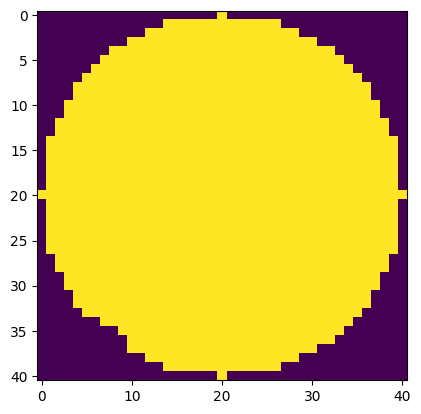

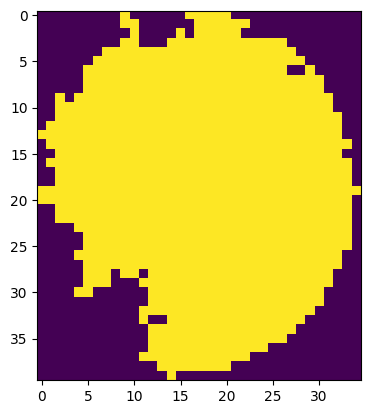

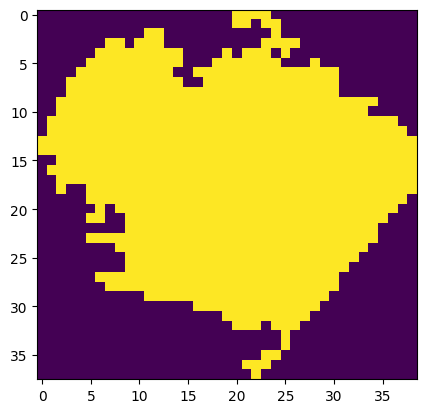

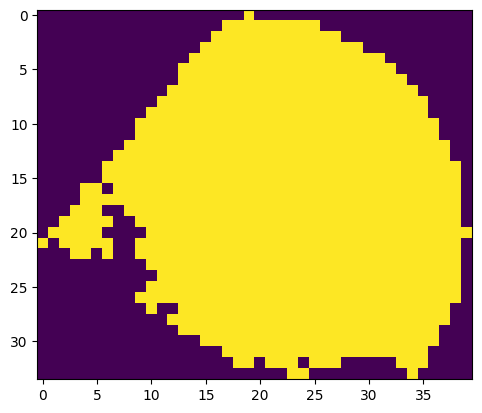

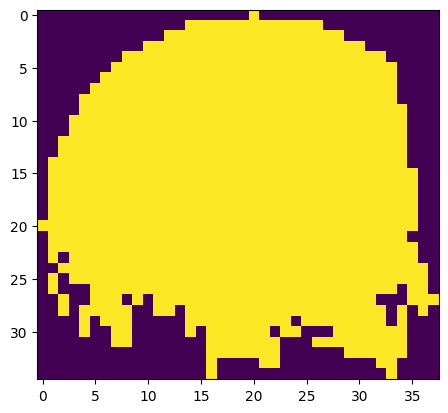

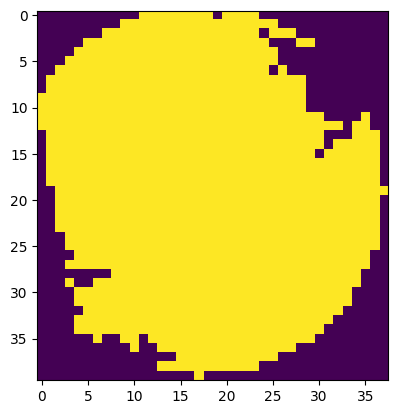

In [6]:
for region in detect.region_props:
    plt.imshow(region.image_filled)
    plt.show()

In [ ]:
plt.imshow(tab3.detectionAlgorithm.maxima_labeled_expanded)

In [ ]:
plt.imshow(detect.imgThresholded_labeled)

In [ ]:
print(detect._labels)

In [ ]:
plt.imshow(detect.labeledImage)